In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from glob import glob
import pandas as pd
from copy import deepcopy
from hydra import initialize, compose
import itertools
from matplotlib.ticker import MaxNLocator
from pprint import pprint

# set paths to various directories based on the machine this code is being executed on
try:
    with initialize(version_base=None, config_path='config'):  
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']
except:
    with initialize(version_base=None, config_path='../../config'):  
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.utils import util
from mejiro.plots import plot_util

In [2]:
pipeline_params = util.hydra_to_dict(config.pipeline)
debugging = pipeline_params['debugging']
total = True

if debugging:
    pipeline_dir = f'{config.machine.pipeline_dir}_dev'
else:
    pipeline_dir = config.machine.pipeline_dir

print(f'pipeline_dir: {pipeline_dir}')

pipeline_dir: /data/bwedig/mejiro/pipeline_dev


In [3]:
# combine CSVs from each run into one CSV
data_dir = os.path.join(pipeline_dir, '00')

detectable_csv = os.path.join(data_dir, 'detectable_pop.csv')
util.delete_if_exists(detectable_csv)
detectable_df = util.combine_all_csvs(data_dir, 'detectable', detectable_csv)

if total:
    total_csv = os.path.join(data_dir, 'total_pop.csv')
    util.delete_if_exists(total_csv)
    total_df = util.combine_all_csvs(data_dir, 'total', total_csv)

Wrote combined CSV to /data/bwedig/mejiro/pipeline_dev/00/detectable_pop.csv
Wrote combined CSV to /data/bwedig/mejiro/pipeline_dev/00/total_pop.csv


In [4]:
# total_df.columns
# hist = total_df.hist(grid=False, figsize=(20, 20))

# detectable_df.columns
# hist = detectable_df.hist(grid=False, figsize=(20, 20))

# slacs_df.columns
# hist = slacs_df.hist(grid=False, figsize=(20, 20))
# plt.savefig(os.path.join(figure_dir, 'slacs_hist.png'))

In [5]:
slacs4_path = os.path.join(repo_dir, 'paper', 'supplemental', 'Bolton2008_Table4.csv')
slacs4_df = pd.read_csv(slacs4_path)

slacs5_path = os.path.join(repo_dir, 'paper', 'supplemental', 'Bolton2008_Table5.csv')
slacs5_df = pd.read_csv(slacs5_path)

In [6]:
survey_params = util.hydra_to_dict(config.survey)
# pprint(survey_params)

source_cut_band = survey_params['source_cut_band']
deflector_cut_band = survey_params['deflector_cut_band']
snr_threshold = survey_params['snr_threshold']

# OVERRIDES
# source_cut_band = 'F129'
# deflector_cut_band = 'F129'
# snr_threshold = 20

select histograms to show

In [7]:
# detectable lenses
velocity_dispersions = detectable_df.loc[:,'velodisp']
masses = detectable_df.loc[:,'massstel'] * 1e12
source_redshifts = detectable_df.loc[:,'redssour']
lens_redshifts = detectable_df.loc[:,'redslens']
einstein_radii = detectable_df.loc[:,'angleins']
num_images = detectable_df.loc[:,'numbimag']
source_magnitudes = detectable_df.loc[:,f'magtsour{source_cut_band}']
lens_magnitudes = detectable_df.loc[:,f'magtlens{deflector_cut_band}']

# total lenses
if total:
    total_velocity_dispersions = total_df.loc[:,'velodisp']
    total_masses = total_df.loc[:,'massstel'] * 1e12
    total_source_redshifts = total_df.loc[:,'redssour']
    total_lens_redshifts = total_df.loc[:,'redslens']
    total_einstein_radii = total_df.loc[:,'angleins']
    total_num_images = total_df.loc[:,'numbimag']
    total_source_magnitudes = total_df.loc[:,f'magtsour{source_cut_band}']
    total_lens_magnitudes = total_df.loc[:,f'magtlens{deflector_cut_band}']

# SLACS
slacs_velocity_dispersions = slacs4_df.loc[:,'sigma']
slacs_source_redshifts = slacs4_df.loc[:,'zBG']
slacs_lens_redshifts = slacs4_df.loc[:,'zFG']
slacs_einstein_radii = slacs5_df.loc[:,'bSIE']

normalize number of images

In [8]:
num_2 = len(num_images[num_images == 2])
num_3 = len(num_images[num_images == 3])
num_4 = len(num_images[num_images == 4])
total = len(num_images)

normalized_num_2 = num_2 / total
normalized_num_3 = num_3 / total
normalized_num_4 = num_4 / total

get SNRs

In [9]:
snr_files = glob(f'{data_dir}/snr_list_*.npy')
snr_list = list(itertools.chain.from_iterable([np.load(f) for f in snr_files]))

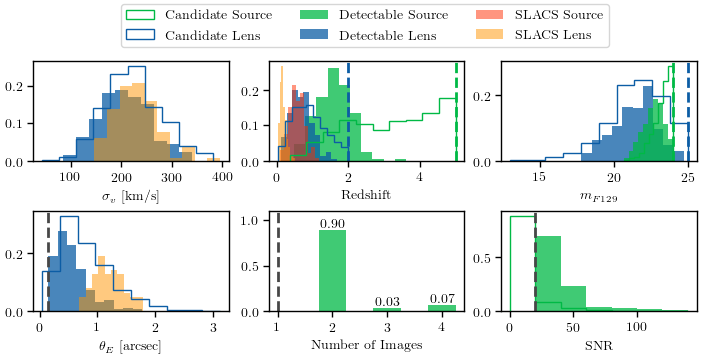

In [10]:
f, ax = plt.subplots(nrows=2, ncols=3, figsize=(7, 3), constrained_layout=True)

# colors
color_lens = 'C0'
color_source = 'C1'
color_slacs_lens = 'C2'
color_slacs_source = 'C3'
color_else = 'C5'

if total: ax[0][0].hist(total_velocity_dispersions, label='Total', histtype='step', color=color_lens, weights=plot_util.weights(total_velocity_dispersions))
ax[0][0].hist(velocity_dispersions, label='Detectable', alpha=0.75, color=color_lens, weights=plot_util.weights(velocity_dispersions))
ax[0][0].hist(slacs_velocity_dispersions, label='SLACS', alpha=0.5, color=color_slacs_lens, weights=plot_util.weights(slacs_velocity_dispersions))
ax[0][0].set_xlabel('$\sigma_v$ [km/s]')
# ax[0][0].set_yscale('log')

if total: ax[0][1].hist(total_source_redshifts, label='Candidate Source', histtype='step', color=color_source, weights=plot_util.weights(total_source_redshifts))
if total: ax[0][1].hist(total_lens_redshifts, label='Candidate Lens', histtype='step', color=color_lens, weights=plot_util.weights(total_lens_redshifts))
ax[0][1].hist(source_redshifts, label='Detectable Source', alpha=0.75, color=color_source, weights=plot_util.weights(source_redshifts))
ax[0][1].hist(lens_redshifts, label='Detectable Lens', alpha=0.75, color=color_lens, weights=plot_util.weights(lens_redshifts))
ax[0][1].hist(slacs_source_redshifts, label='SLACS Source', alpha=0.5, color=color_slacs_source, weights=plot_util.weights(slacs_source_redshifts))
ax[0][1].hist(slacs_lens_redshifts, label='SLACS Lens', alpha=0.5, color=color_slacs_lens, weights=plot_util.weights(slacs_lens_redshifts))
ax[0][1].axvline(survey_params['source_z_max'], color=color_source, linestyle='--')
ax[0][1].axvline(survey_params['deflector_z_max'], color=color_lens, linestyle='--')
# ax[0][1].set_yscale('log')
ax[0][1].set_xlabel('Redshift')

# x1, x2, y1, y2 = 0, 2.25, 0.5, 1e3
# zoom_axes = ax[0][1].inset_axes(bounds=[0.475,0.3,0.425,0.45], xlim=(x1, x2), ylim=(y1, y2))
# zoom_axes.hist(source_redshifts, label='Detectable Source', alpha=0.75)
# zoom_axes.hist(lens_redshifts, label='Detectable Lens', alpha=0.75)
# zoom_axes.hist(slacs_source_redshifts, label='SLACS Source', alpha=0.5, color='y')
# zoom_axes.hist(slacs_lens_redshifts, label='SLACS Lens', alpha=0.5, color='r')
# zoom_axes.set_yscale('log')
# zoom_axes.tick_params(axis='y', which='both', left=False, labelleft=False)
# zoom_axes.set_xticks([0, 1.5])
# ax[0][1].indicate_inset_zoom(zoom_axes, edgecolor="black")

if total: ax[0][2].hist(total_source_magnitudes, histtype='step', color=color_source, weights=plot_util.weights(total_source_magnitudes))
if total: ax[0][2].hist(total_lens_magnitudes, histtype='step', color=color_lens, weights=plot_util.weights(total_lens_magnitudes))
ax[0][2].hist(lens_magnitudes, alpha=0.75, color=color_lens, weights=plot_util.weights(lens_magnitudes))
ax[0][2].hist(source_magnitudes, alpha=0.75, color=color_source, weights=plot_util.weights(source_magnitudes))
ax[0][2].axvline(survey_params['source_cut_band_max'], linestyle='--', color=color_source)
ax[0][2].axvline(survey_params['deflector_cut_band_max'], linestyle='--', color=color_lens)
# ax[0][2].set_yscale('log')
assert source_cut_band == deflector_cut_band, 'Source and deflector cut bands must be the same for the label on this plot to be true'
ax[0][2].set_xlabel(r'$m_{%s}$' % source_cut_band)
# ax[0][2].invert_xaxis()

if total: ax[1][0].hist(total_einstein_radii, histtype='step', color=color_lens, weights=plot_util.weights(total_einstein_radii))
ax[1][0].hist(einstein_radii, alpha=0.75, color=color_lens, weights=plot_util.weights(einstein_radii))
ax[1][0].hist(slacs_einstein_radii, alpha=0.5, color=color_slacs_lens, weights=plot_util.weights(slacs_einstein_radii))
ax[1][0].axvline(survey_params['min_image_separation'] / 2, linestyle='--', color=color_else)
ax[1][0].set_xlabel(r'$\theta_E$ [arcsec]')
# ax[1][0].set_yscale('log')
# ax[1][0].set_xlim([0,2])

# counts, edges, bars = ax[1][1].hist(num_images, label='Detectable', alpha=0.75, color=color_source)
bar_2 = ax[1][1].bar(2, normalized_num_2, label='Detectable', alpha=0.75, color=color_source, width=0.5)
bar_3 = ax[1][1].bar(3, normalized_num_3, alpha=0.75, color=color_source, width=0.5)
bar_4 = ax[1][1].bar(4, normalized_num_4, alpha=0.75, color=color_source, width=0.5)
ax[1][1].axvline(1, linestyle='--', color=color_else)
ax[1][1].set_xlabel('Number of Images')
# labels = [int(v) if v > 0 else '' for v in counts]
ax[1][1].bar_label(bar_2, labels=[f'{normalized_num_2:.2f}'], label_type='edge')
ax[1][1].bar_label(bar_3, labels=[f'{normalized_num_3:.2f}'], label_type='edge')
ax[1][1].bar_label(bar_4, labels=[f'{normalized_num_4:.2f}'], label_type='edge')
# ax[1][1].set_xlim([0.8, 4.8])  # make some horizontal space for the bar labels
ax[1][1].set_ylim([0, 1.1])  # make some vertical space for the bar labels
ax[1][1].xaxis.set_major_locator(MaxNLocator(integer=True))
# ax[1][0].ticklabel_format(axis='y', style='plain', scilimits=(0,0))

bin_width = snr_threshold
snr_list = [snr for snr in snr_list]
bins = np.arange(min(snr_list), max(snr_list) + bin_width, bin_width)
_, bins, _ = ax[1][2].hist(snr_list, bins=bins, label='Total', histtype='step', color=color_source, weights=plot_util.weights(snr_list))
detectable_snrs = [i for i in snr_list if i > snr_threshold]
ax[1][2].hist(detectable_snrs, bins=bins[1:], label='Detectable', alpha=0.75, color=color_source, weights=plot_util.weights(detectable_snrs))
ax[1][2].axvline(x=snr_threshold, linestyle='--', color=color_else)
ax[1][2].set_xlabel('SNR')
# ax[1][2].set_yscale('log')

# create legend using colors and labels from the redshift panel
handles, labels = ax[0][1].get_legend_handles_labels()
f.legend(handles, labels, loc='upper center', ncols=3, bbox_to_anchor=(0.52, 1.2))

plt.savefig(os.path.join(figure_dir, 'skypy_pop_hist.png'))
plt.show()

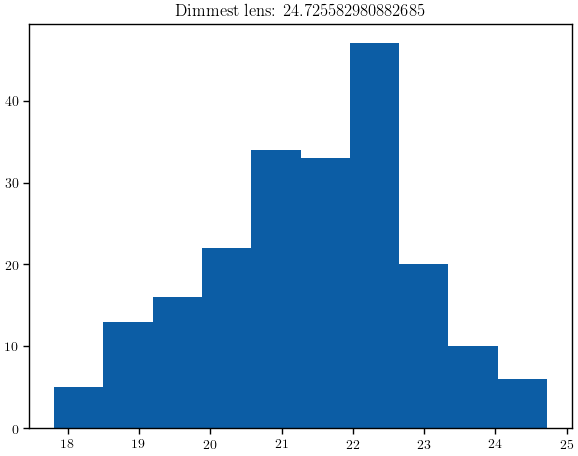

In [11]:
plt.hist(lens_magnitudes)
plt.title(f'Dimmest lens: {np.max(lens_magnitudes)}')
plt.show()

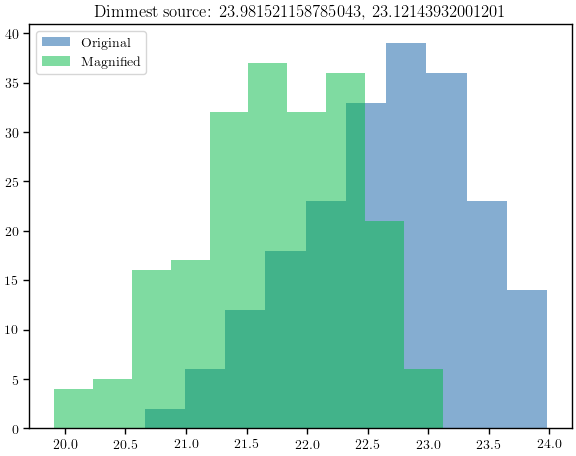

In [12]:
magnified_source = detectable_df.loc[:,f'magtsourMagnified{source_cut_band}']

plt.hist(source_magnitudes, label='Original', alpha=0.5)
plt.hist(magnified_source, label='Magnified', alpha=0.5)
plt.title(f'Dimmest source: {np.max(source_magnitudes)}, {np.max(magnified_source)}')
plt.legend()
plt.show()

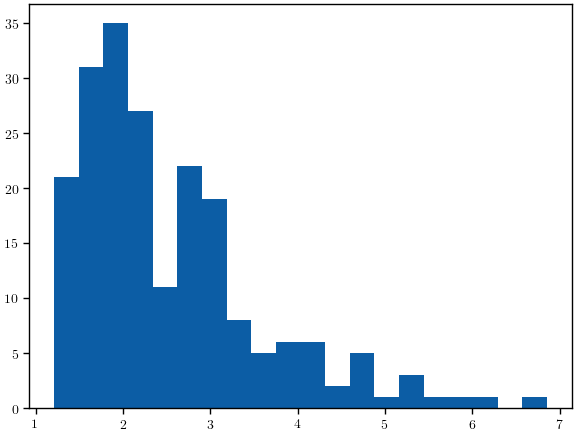

Percentage of detectable lenses with magnification > 3: 24.76%


In [13]:
magnification = detectable_df.loc[:,'magnsour']
plt.hist(magnification, bins=20)
plt.show()

magn_gtr_3 = detectable_df.loc[magnification > 3, :]
print(f'Percentage of detectable lenses with magnification > 3: {len(magn_gtr_3) / len(detectable_df) * 100:.2f}%')

In [14]:
einstein_radii.sort_values(ascending=True).head(10)

43     0.151508
28     0.160936
138    0.164125
56     0.171486
184    0.181207
154    0.183393
114    0.184889
171    0.187131
178    0.191819
122    0.195728
Name: angleins, dtype: float64

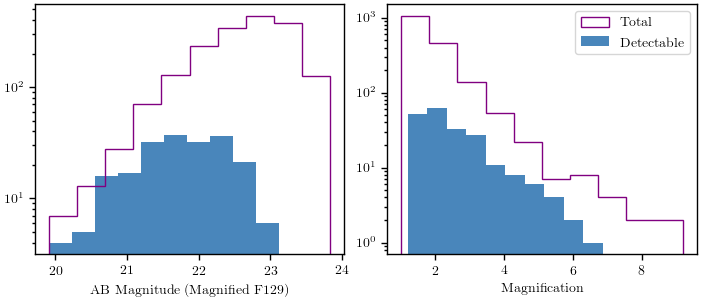

In [15]:
total_magnified_source = total_df.loc[:,f'magtsourMagnified{source_cut_band}']  # magtsourMagnifiedF129
magnified_source = detectable_df.loc[:,f'magtsourMagnified{source_cut_band}']

total_magnification = total_df.loc[:,'magnsour']  
magnification = detectable_df.loc[:,'magnsour']

f, ax = plt.subplots(1, 2, figsize=(7, 3), constrained_layout=True)
ax[0].hist(total_magnified_source, label='Total', histtype='step', color='purple')
ax[0].hist(magnified_source, label='Detectable', alpha=0.75)
ax[0].set_xlabel(f'AB Magnitude (Magnified {source_cut_band})')
ax[0].set_yscale('log')
ax[1].hist(total_magnification, label='Total', histtype='step', color='purple')
ax[1].hist(magnification, label='Detectable', alpha=0.75)
ax[1].set_xlabel('Magnification')
ax[1].set_yscale('log')
plt.legend()
plt.show()

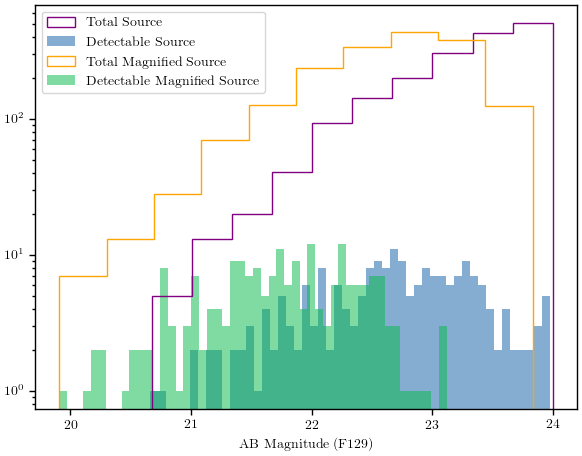

In [16]:
plt.hist(total_source_magnitudes, label='Total Source', histtype='step', color='purple')
plt.hist(source_magnitudes, label='Detectable Source', alpha=0.5, bins=50)
plt.hist(total_magnified_source, label='Total Magnified Source', histtype='step', color='orange')
plt.hist(magnified_source, label='Detectable Magnified Source', alpha=0.5, bins=50)
plt.xlabel(f'AB Magnitude ({source_cut_band})')
plt.yscale('log')
plt.legend()
plt.show()